## 安装环境

1. 新建虚拟环境

conda create -n paddle python=3.9 --yes

2. 激活虚拟环境

conda activate paddle

3. 安装依赖软件

conda install paddlepaddle-gpu cudatoolkit
python -m pip install opencv-contrib-python==4.4.0.46 paddleocr paddlenlp==2.4

## 测试环境

In [1]:
import paddle # type: ignore
paddle.device.is_compiled_with_cuda()

True

## 跑流程

### 提取图片上的文字

In [4]:
from paddleocr import PaddleOCR, draw_ocr  # type: ignore
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# paddleocr目前支持中英文、英文、法语、德语、韩语、日语等80个语种，可以通过修改lang参数进行切换
ocr = PaddleOCR(use_angle_cls=False, lang="ch", det_db_box_thresh=0.3, use_dilation=True)
# 印章部分造成的文本遮盖，影响了文本识别结果，因此可以考虑通道提取，去除图片中的红色印章
#读入图像,三通道
image=cv2.imread("./test_img/hetong3.jpg",cv2.IMREAD_COLOR) #timg.jpeg
print(image.shape)
#获得三个通道
Bch,Gch,Rch=cv2.split(image)
#保存三通道图片
cv2.imwrite('blue_channel.jpg',Bch)
cv2.imwrite('green_channel.jpg',Gch)
cv2.imwrite('red_channel.jpg',Rch)

[2024/04/10 16:22:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/wushaogui/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=True, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/wushaogui/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, re

True

[2024/04/10 16:06:16] ppocr DEBUG: dt_boxes num : 24, elapsed : 1.3868777751922607
[2024/04/10 16:06:16] ppocr DEBUG: rec_res num  : 24, elapsed : 0.5372314453125


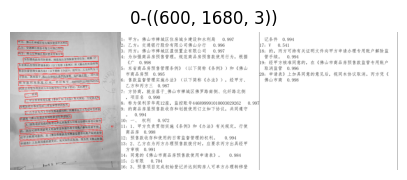

甲方：佛山市禅城区住房城乡建设和水利局
乙方：交通银行股份有限公司佛山分行
丙方：佛山市禅城区盈恒置业有限公司
为加强商品房预售管理，规范商品房预售款使用行为，根据《广
东省商品房预售管理条例》（以下简称《条例》）和《佛山市商品房预
售款监督管理实施办法》（以下简称《办法》），经甲方、乙方和丙方三
方协商，就坐落于_佛山市禅城区佛罗路南侧、化纤路北侧，项目名
称为保利芳华苑12座，监控账号446899991010003029262
的商品房屋预售款收存和划拨使用订立如下协议，共同遵守。
一、 权利
1、甲方负责贯彻实施《条例》和《办法》有关规定，行使商品房
预售款收存和使用的日常监督管理的权利。
2、乙方在为丙方办理预售款拨付时，应要求丙方出具经甲方审核
同意的《佛山市商品房预售款使用申请表》。
公有限
3、预售项目完成初始登记并达到购房人可单方办理转移登记条件
V
的，丙方可持有关证明文件向甲方申请办理专用账户解除监管手续。
经甲方核准同意的，在《佛山市商品房预售款监管专用账户取消监管
申请表》上加具同意的意见后，视同本协议取消。丙方凭《佛山市商
cost time:2.178391218185425s


In [3]:
import time
from my_read_code_tools import *

start=time.time()

# 合同文本信息提取
# 合同照片的红色通道被分离，获得了一张相对更干净的图片，此时可以再次使用ppocr模型提取文本内容
img_path = './red_channel.jpg' # 使用红色通道图片排除印章影响
result = ocr.ocr(img_path, cls=False)
# 可视化结果，不想可视化可以注释下面几行代码
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]
scores = [line[1][1] for line in result[0]]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./simfang.ttf')
im_show = Image.fromarray(im_show)
vis = np.array(im_show)
# im_show.show()
show_images([vis])
#忽略检测框内容，提取完整的合同文本：
txts = [line[1][0] for line in result[0]]
all_context = "\n".join(txts)
print(all_context)

end=time.time()
print('cost time:{}s'.format(end-start))

### 关键信息抽取

In [4]:
from paddlenlp import Taskflow # type: ignore

schema = ["甲方","乙方","总价","大写","小写","项目"]
ie = Taskflow('information_extraction', schema=schema)
ie.set_schema(schema)

[2024-04-10 11:21:40,007] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.tokenizer.ErnieTokenizer'> to load '/home/wushaogui/.paddlenlp/taskflow/information_extraction/uie-base'.


In [5]:
start=time.time()

result = ie(all_context)
print(result)

end=time.time()
print('cost time:{}s'.format(end-start))

[{'甲方': [{'text': '佛山市禅城区住房城乡建设和水利局', 'start': 3, 'end': 19, 'probability': 0.8409922679564374}], '乙方': [{'text': '交通银行股份有限公司佛山分行', 'start': 23, 'end': 37, 'probability': 0.8475471161905048}], '项目': [{'text': '保利芳华苑12座', 'start': 183, 'end': 191, 'probability': 0.5095629052180897}]}]
cost time:0.20002102851867676s
